In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates  as pdt
from pyrocko import gf
import sim_fractal as frct

class GFSolver:
    
    """
    This class contains engine that solves Green's Function and makes calculations according to that.
    
    Parameters:
    ----------
        - store_id : string
            Store ID to specify engine in Pyrocko. 
            
        - site : 
    """
    
    def __init__(self, store_id = "gfs_ismetpasa", site = "kinherd"):
        self.store_id = store_id
        self.site = site
        
        if not os.path.exists(self.store_id):
            gf.ws.download_gf_store(site = self.site, store_id = self.store_id)
            
        self.engine = gf.LocalEngine(store_superdirs=["."])
        

class TemporalTable:
    
    """
    This class specifies time dimension of the SAR acquisitions.
    
    Parameters:
    ----------
        - Ndate :integer
            Number of SAR recordings to create InSAR data. 
            This number should be one higher than the number of interferograms.
            E.g. in order to create a stack of 9 interferograms, Ndate should be 10. 
            
        - TempRsl : integer
            Number of days between successive SAR recordings.
            
        - PrmDt : string
            Date of the first SAR acquisition. Formatted in YYYY-MM-DD.
    """
    
    def __init__(self, Ndate = 10, TempRsl = 72, PrmDt = "2018-05-12"):
        self.Ndate = Ndate
        self.TempRsl = TempRsl
        self.PrmDt = PrmDt
        
    def create(self):
        
        """
        This function creates temporal table according to the specifications given in the class.
        """
        
        TempTbl = np.linspace(0, self.Ndate -1, self.Ndate) * self.TempRsl
        PrmNum = pdt.datestr2num(self.PrmDt)
        ifgsNum = np.add(TempTbl, PrmNum)
        ifgsDtNum = pdt.num2date(ifgsNum)
        
        ifgsDt = []
        
        for i in range(len(TempTbl)):
            ifgDt = str(ifgsDtNum[i].year)+'-'+str(ifgsDtNum[i].month)+'-'+str(ifgsDtNum[i].day)
            ifgsDt.append(ifgDt)
            
        self.TempTbl = TempTbl
        self.ifgsNum = ifgsNum
        self.ifgsDt = ifgsDt
        
    
class Grid:
    
    """
    This class specifies physical dimensions of the ground. Grid is created from -(NS_size and EW_size)/2 
    to (NS_size and EW_size)/2.
    
    Parameters:
    ----------
        - NS_size : integer
            Length of the creep area in NS direction in meters.
            
        - EW_size : integer
            Length of the creep area in EW direction in meters.
            
        - grdSize : integer
            Length of each pixel in terms of meter. 
            !!CAUTION!! 
            Code does not check if NS_size or EW_size can be divided by grdSize, 
            user must take care of it. 
    """
    
    def __init__(self, NS_size, EW_size, grdSize):
        self.gridSize = grdSize
        NSwidth = NS_size / 2
        EWwidth = EW_size / 2
        E = [-EWwidth, EWwidth]
        N = [-NSwidth, NSwidth]
        
        Egrid, Ngrid = np.mgrid[E[0]:E[1]:self.gridSize, N[0]:N[1]:self.gridSize]
        
        self.Egrid = Egrid
        self.Ngrid = Ngrid
        self.gridShape = Egrid.shape

        
class Satellite:
    
    """
    This class prepares satellite information for the engine to create InSAR images.
    
    Parameters:
    ----------
        - look : list
            A list of minimum and maximum looking angles. 
            Looking angle of a point is defined as the angle between the line that passes through the satellite 
            and the point interested and it is normal to the ground. List must be in the form of [minAngle, maxAngle] 
            and angles should be given in degrees. Minimum angle is the looking angle of the closest point 
            meanwhile maximum angle is the looking angle of the furthest point.
            
        - heading : list
            A list of headings of the satellites. Heading angle is the angle between the azimuth and the North 
            (anti-clock). Each value in the heading list represents another satellite. 
            Angles should be given in degrees. List should contain pairs of angles which sum up to 360 degrees 
            because of the motion of the satellite and the Earth.
            
        - maxPB : integer
             Maximum perpendicular distance between two passings of satellite from the same location. In meters.
            
        - GFSolver :  GFSolver class object 
            GFSolver class that will be used in the simulation. 
            
        - TemporalTable : TemporalTable class object
            TemporalTable class that will be used in the simulation.
            
        - Grid: Grid class object
            Grid class that will be used in the simulation.
    """
    
    
    def __init__(self, look, heading, maxPB, GFSolver, TemporalTable, Grid):
        self.GFSolver = GFSolver
        self.TemporalTable = TemporalTable
        self.Grid = Grid
        self.Esize, self.Nsize = Grid.gridShape
        self.heading = heading
        self.lookA = np.tile(np.linspace(np.deg2rad(look[0]), np.deg2rad(look[1]), self.Esize), self.Nsize)
        
        PerpBsl = np.random.randint(-maxPB, maxPB, size = TemporalTable.Ndate)
        PerpBsl[0] = 0
        
        self.PerpBsl = PerpBsl
        
    def position(self):
        
        """
        This function creates SatelliteTarget for GFSolver's engine according to the specifications given in the class.
        """
        
        satellites = []
        for i in range(len(self.heading)):
            phi = np.empty(self.Esize * self.Nsize)
            phi.fill(np.deg2rad(self.heading[i-1]))
            satellite_target = gf.SatelliteTarget(north_shifts = self.Grid.Ngrid, east_shifts = self.Grid.Egrid,
                                                  tsnapshot = 24 * 3600, interpolation = "nearest_neighbor",
                                                  phi = phi, theta = self.lookA, store_id = self.GFSolver.store_id)
            satellites.append(satellite_target)
        self.satellites = satellites
        
        
class Fault:
    
    """
    This class specifies features of the fault. In order to automatize simulation, strike, dip and rake values 
    can be given as lists.
    
    Parameters:
    ----------
        - length : integer
            Length of the fault in meters.
            
        - depth : integer
            Depth of the fault in meters.
            
        - width : integer
            Width of the fault in meters.
            
        - strike : integer or list
            Strike angle of the fault in degrees.
            
        - dip : integer or list
            Dip angle of the fault in degrees.
            
        - rake : integer or list
            Rake angle of the fault in degrees.
            
        - slip : float
            List of slip rates of fault given in meter per year. 
            First two elements are slip rate of different layers of the ground, 
            the third element is the slip rate of episodic creep. 
            
        - episodicStep : integer
            Numver of days between each episodic creep.
            
        - episodicLength : integer
            Length of the episodic creep in days.
        
        - episodic_creep : list
            List of integers denoting which parts are creep in the splitted fault parts.
    
    """

    
    def __init__(self, length, depth, width, strike, dip, rake, slip, episodicStep, episodicLength):
        self.length = length
        self.depth = depth
        self.width = width
        
        self.strike = strike
        self.dip = dip
        self.rake = rake
        
        self.slip = slip
        
        self.episodicStep = episodicStep
        self.episodicLength = episodicLength


class Simulator:
    
    """
    This class executes all the codes that produces simulation data under a structure.
    """
    
    def displacement(self, GFSolver, TemporalTable, Grid, Satellite, Fault):
        
        """
        This function calculates displacement by using GFSolver, TemporalTable, Grid,
        Satellite and Fault classes. Simulation calculates displacement for each satellite
        heading, strike, dip and rake combinations.
        
        Parameters:
        ----------
            - GFSolver : GFSolver Class Object
                GFSolver class to call the engine that makes calculations.
                
            - TemporalTable : TemporalTable Class Obejct
                TemporalTable class to get information about the time in calculations.
                
            - Grid : Grid Class Object
                Grid class to get information about the physical dimension in calculations. 
                
            - Satellite : Satellite Class Object
                Satellite class to get information about the satellites in calculations. 
            
            - Fault : Fault Class Object
                Fault class to get information about the fault in calculations. dtype = 
        
         Returns
        ----------
            [#satellite headings * #strike * #dip * #rake, Ndate-1, NS_size/grdSize, EW_size/grdSize] 
        
        """
        
        year = 365.25
        km = 1e3
        self.Esize, self.Nsize = Grid.gridShape
        
        N = Fault.episodicLength
        dtNum = TemporalTable.ifgsNum
        
        creepSlip = Fault.slip[2] / N
        creepStart = np.arange(2 * N, int(np.max(dtNum)) - int(np.min(dtNum)) - 3, Fault.episodicStep)
        
        X = np.arange(1, int(np.max(dtNum)) - int(np.min(dtNum)))
        Y = np.zeros(len(X), np.float32)
        
        for i in creepStart:
            Y[i-N:i+N] = np.logical_and(X[i-N:i+N] >= i - int(N/2), X[i-N:i+N] <= i + int(N/2) - 1)
            Y[i-N:i+N] = Y[i-N:i+N] * np.bartlett((i+N) - (i-N)) * creepSlip
        
        ##CHECK IF epsCrpID SHOULD BE IN FAULT OR SIMULATION!! SOLVED
        epsCrpID = [3,6]
        creepMax = Fault.slip[1]
        ##CHECK IF Nshift and N ARE THE SAME THING!! THEY ARE NOT, ADJUST IT!!
        creep = np.zeros((N * 2 - 1), np.float32)
        creep[0] = creepMax
        shift = np.zeros((N * 2 - 1, 2), np.float32)
        
        LOS = np.zeros((len(Fault.strike) * len(Fault.dip) * len(Fault.rake) * len(Satellite.satellites), len(TemporalTable.TempTbl) -1 , self.Nsize, self.Esize))
        
        data = 0
        for satellite in Satellite.satellites:
            for strike in Fault.strike:
                
                for i in range(1, len(shift), 2):
                    n = i//2 + 1
                    step = n * Fault.length[1]
                    creep[i] = creepMax - (n * (creepMax/N))
                    creep[i+1] = creepMax - (n * (creepMax/N))
                    shift[i,:] = np.multiply(step, [np.cos(np.deg2rad(90 - strike)), np.sin(np.deg2rad(90 - strike))])
                    shift[i+1,:] = np.multiply(step * -1, [np.cos(np.deg2rad(90 - strike)), np.sin(np.deg2rad(90 - strike))])
                
                for rake in Fault.rake:
                    for dip in Fault.dip:

                        
                        displacement = []
                        
                        for interferogram in np.arange(len(TemporalTable.TempTbl)):
                            t = np.abs(TemporalTable.TempTbl[interferogram])
                            
                            if interferogram == 0:
                                continue
                            
                            intSlip = (Fault.slip[0] / year) * t
                            epsCrp = np.sum(Y[0: int(t)])
                            
                            intS_source = gf.RectangularSource(lat = 0, lon = 0, north_shift = 0, east_shift = 0,
                                                              depth = Fault.depth[0], width = Fault.width[0], length = Fault.length[0],
                                                              dip = dip, rake = rake, strike = strike, slip = intSlip)
                            intS_result = GFSolver.engine.process(intS_source, [satellite])
                            latitude = intS_result.request.targets[0].coords5[:, 2] / km
                            longitude = intS_result.request.targets[0].coords5[:, 3] / km
                            intS_los = intS_result.results_list[0][0].result["displacement.los"]
                            
                            creep_los = np.zeros(Grid.gridShape[0] * Grid.gridShape[1], np.float32)
                            
                            for i in range(len(creep)):
                                crp = creep[i] / year * t
                                patchCrp_source = gf.RectangularSource(lat = 0, lon = 0, north_shift = shift[i, 1], east_shift = shift[i, 0],
                                                              depth = Fault.depth[1], width = Fault.width[1], length = Fault.length[1],
                                                              dip = dip, rake = rake, strike = strike, slip = crp)
                                patchCrp_result = GFSolver.engine.process(patchCrp_source, [satellite])
                                patchCrp_los = patchCrp_result.results_list[0][0].result
                                creep_los = creep_los + patchCrp_los["displacement.los"]
                            
                            epsCrp_los = np.zeros(Grid.gridShape[0] * Grid.gridShape[1], np.float32)
                            
                            for i in range(len(epsCrpID)):
                                patchEpsCrp_source = gf.RectangularSource(lat = 0, lon = 0, north_shift = shift[epsCrpID[i], 1], east_shift = shift[epsCrpID[0], 0],
                                                              depth = Fault.depth[1], width = Fault.width[1], length = Fault.length[1],
                                                              dip = dip, rake = rake, strike = strike, slip = epsCrp)
                                patchEpsCrp_result = GFSolver.engine.process(patchEpsCrp_source, [satellite])
                                patchEpsCrp_los = patchEpsCrp_result.results_list[0][0].result
                                epsCrp_los = epsCrp_los + patchEpsCrp_los["displacement.los"]
                                
                            Dlos = (intS_los + creep_los + epsCrp_los)
                            displacement.append(Dlos)
                        displacement = np.array(displacement)
                        LOS[data,:,:,:] = displacement.reshape((TemporalTable.Ndate - 1, self.Nsize, self.Esize))
                        data += 1
                        
        return LOS
    
    def tropospheric_noise(self, number_of_samples, Grid):
        
        """
        This function generates trophospheric noise.
        
        Parameters:
        ----------
            - number_of_samples : integer
                Number of noise samples.
                
            - Grid : Grid Class Object
                Grid class to get pixel informations.
        """
        
        self.Esize, self.Nsize = Grid.gridShape
        
        turbulences = np.zeros((number_of_samples, self.Nsize, self.Esize))
        
        for data in range(number_of_samples):
            turbulence = frct.fractal_surface_atmos(shape = (self.Nsize, self.Esize), resolution = Grid.gridSize/10, p0 = 1.00, freq0 = 1e-3,
                                                    regime = (0.01, 0.9999, 1.0), beta = (5/3, 8/3, 2/3))
            
            turbulences[data,:,:] = turbulence
        
        return turbulences

ModuleNotFoundError: No module named 'pyrocko'

In [13]:
GF = GFSolver()
TMP = TemporalTable()
TMP.create()
GRD = Grid(64e3, 64e3, 1e3)
STL = Satellite([34, 53], [-166, -90, -14, 14, 90, 166], 250, GF, TMP, GRD)
STL.position()
F = Fault(length = [50e3, 5e3], width = [100e3, 5e3], depth = [60e3, 3e3], strike = list(range(0,90,5)), dip = list(range(80,90,1)), rake = [160], slip = [0.022, 0.015, 0.005], episodicStep =  45, episodicLength = 5)

In [14]:
Sim = Simulator()
LOS = Sim.displacement(GF, TMP, GRD, STL, F)
noise = Sim.tropospheric_noise(5000, GRD)

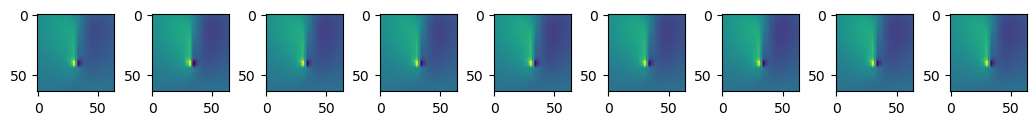

In [17]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i = 0
s0.imshow(LOS[i][0], interpolation="nearest")
s1.imshow(LOS[i][1], interpolation="nearest")
s2.imshow(LOS[i][2], interpolation="nearest")
s3.imshow(LOS[i][3], interpolation="nearest")
s4.imshow(LOS[i][4], interpolation="nearest")
s5.imshow(LOS[i][5], interpolation="nearest")
s6.imshow(LOS[i][6], interpolation="nearest")
s7.imshow(LOS[i][7], interpolation="nearest")
s8.imshow(LOS[i][8], interpolation="nearest")

plt.show()

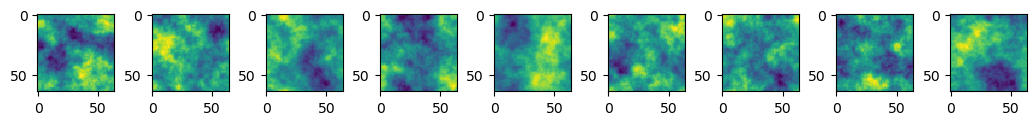

In [31]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i = 9
s0.imshow(noise[0], interpolation="nearest")
s1.imshow(noise[1], interpolation="nearest")
s2.imshow(noise[2], interpolation="nearest")
s3.imshow(noise[3], interpolation="nearest")
s4.imshow(noise[4], interpolation="nearest")
s5.imshow(noise[5], interpolation="nearest")
s6.imshow(noise[6], interpolation="nearest")
s7.imshow(noise[7], interpolation="nearest")
s8.imshow(noise[8], interpolation="nearest")

plt.show()